# Preprocessing and Model Selection Example Analysis
### by Yaniv Amir   11/2024

## Outline of Analysis
1. Exploratory data analysis: Understanding the target variable and the dif#ferent features
2. Drividing the dataset into training and test sets.
3. ### Develop a simple Logistic Regression model as baseline model ####
  3.1. simple preprocessing steps: SimpleImputer
  3.2. Cross validation without hyperparameter tuning
4. ### Develop an advanced Logistic Regression model ###
   4.1. more advanced preprocessor steps:
      
      4.1.1. Remove highly correlated features
     
      4.1.2. Outlier removal
      
      4.1.3. IterativeImputer
  
  4.2. Cross validation with regularization, L1 and L2, and hyperparameter tuning using GridSearchCV

  4.3. Best model evaluation

  4.4. Fedature Importance

5. #### Dvelop a Random Forest Model ###
  5.1. Preprocessing

  5.2 Cross validation and hyperparameter tuning using an exhaustive   GridSearchCV

  5.3. Model Confidence metrics

  5.4. Feature Importance

6. #### Other models to consider with this dataset



In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime,timedelta
from collections import Counter
from sklearn.model_selection import train_test_split,StratifiedKFold,StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline,FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.experimental import enable_iterative_imputer
from scipy.stats import ttest_ind, chi2_contingency, ks_2samp
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from copy import deepcopy
import warnings
import time
from google.colab import drive
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
drive.mount('/content/drive')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Exploratory data analysis

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Ds_CaseStudy_Dataset.csv')
target = df['Retention_Status']

Target Variable Distribution:

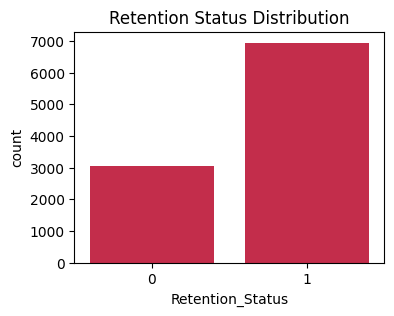

In [ ]:
plt.figure(figsize=(4, 3))
sns.countplot(df, x='Retention_Status', color='crimson')
plt.title('Retention Status Distribution')
plt.show()

Conclusion: Target Variable is imbalanced.

Given the uneven distribution of the target variable, I will use stratified k-fold cross-validation in my models, as well as balanced class weights to ensure that each fold maintains a representative proportion of the original class labels. In addtion, to account for the class imbalance, I'll utilize a more comprehensive evaluation metric. The specific details of this metric will be elaborated on later in the analysis.


#### Features Variables:

In [ ]:
pd.DataFrame([df.dtypes,df.isna().sum()],index=['dtype','missing_values']).T.iloc[2:,:]

,dtype,missing_values
Age,float64,1000
Gender,object,1000
Region,object,0
Income,float64,1000
Tenure,float64,1000
Last_Interaction_Date,object,0
Number_of_Purchases,int64,0
Average_Order_Value,float64,0
Total_Spend,float64,0
Customer_Complaints,int64,0


Conclusions:
1. Data is a mixture of numerical and categorical features
2. "Last_interaction_Date" is an object type. It needs to be converted into datetime
3. Five features have 1000 missing values, each (even though description mentioned otherwise)




Handling "Last_Interaction_Date" Variable:

1. Change into datetime.

2. Transform the feature into "Days_From_last_interaction" to transform it into numeric and more interpretable in the context of a model. Other transformations are applicable given input and relevance from other stakeholders.
Assumption: Used the most recent date specified in the feature as "current" and compared all other dates to it.

In [ ]:
df['Last_Interaction_Date'] = pd.to_datetime(df['Last_Interaction_Date'])
df['Days_From_Last_Interaction'] = (df['Last_Interaction_Date'].max() - df['Last_Interaction_Date']).dt.days
df.drop(['Last_Interaction_Date'], axis =1 ,inplace=True)


In [ ]:
# removing the target variable and custumer ID
y = df['Retention_Status']
customerID = df['Customer_ID']
df.drop(['Retention_Status','Customer_ID'],axis=1,inplace=True)

Numerical and Categorical Feature Values' Distributions:

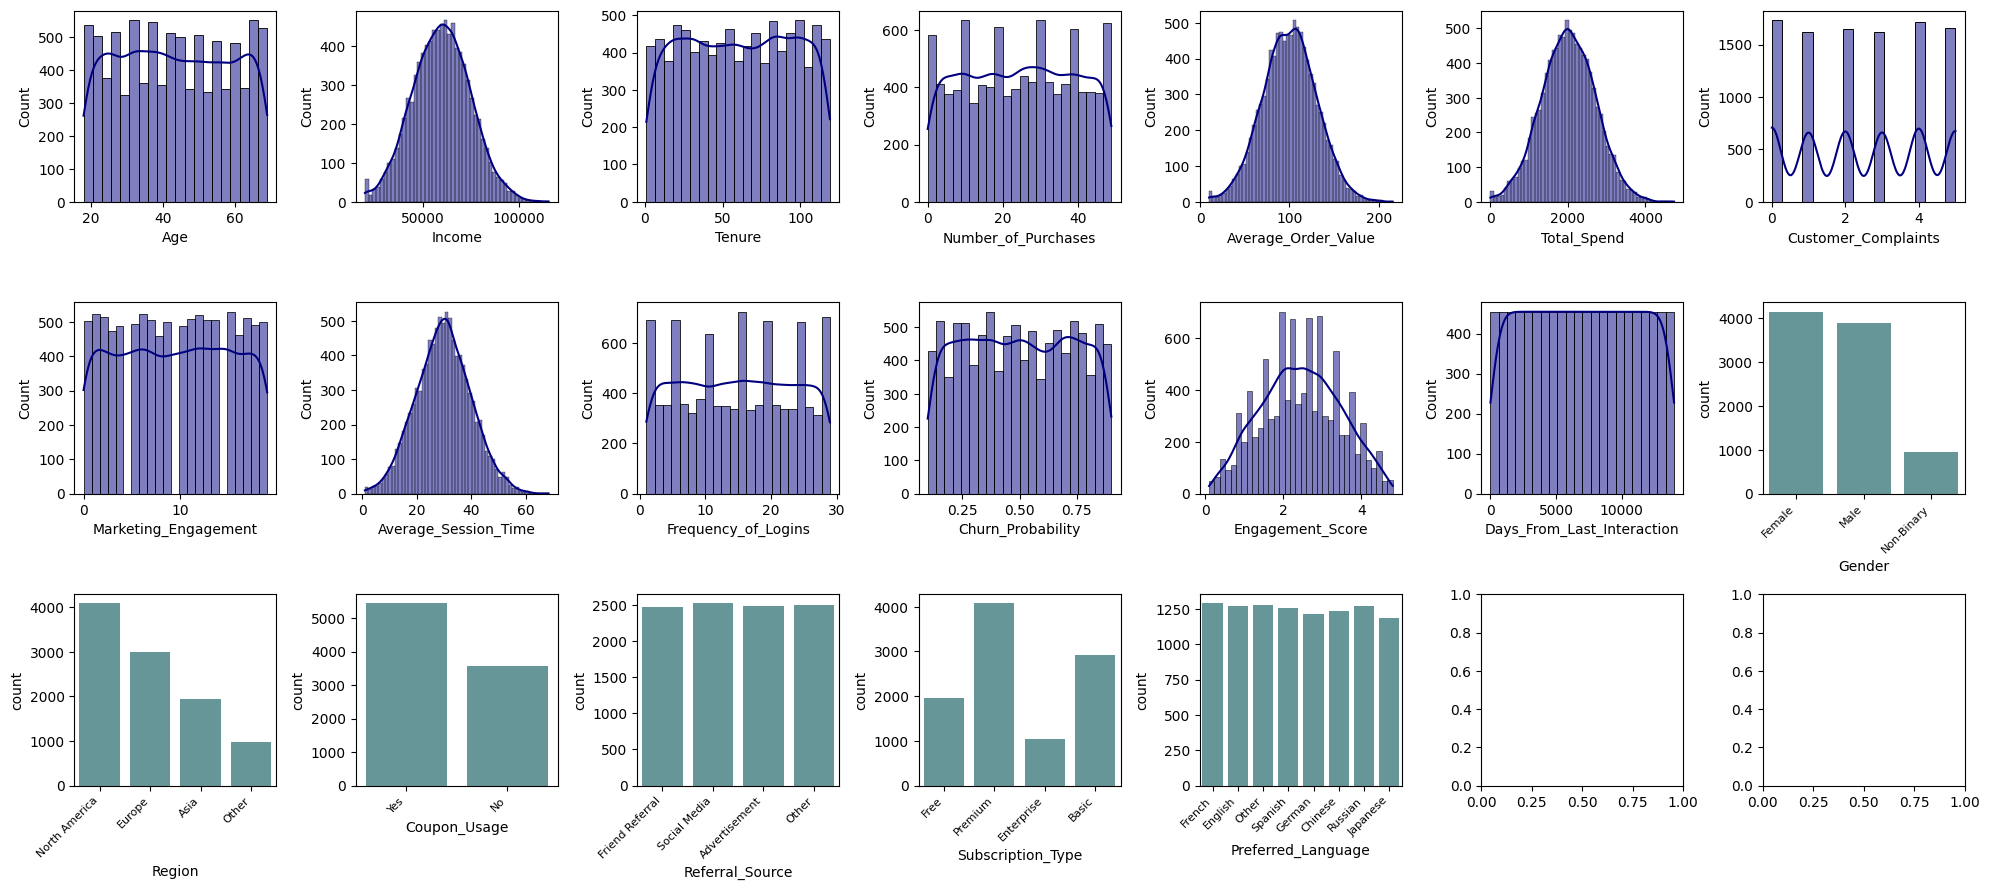

In [ ]:
numeric_features = df.select_dtypes(include=['number']).columns
categorical_features = df.select_dtypes(include=['object']).columns
fig,axs = plt.subplots(3,int(len(numeric_features)/2)+1,figsize=(20,9))
j=0
for i,ax in enumerate(axs.flatten()):
  if i < len(numeric_features): #numerical features
    sns.histplot(df[numeric_features],x=numeric_features[i],ax=ax,color = 'navy',kde=True)
  elif j< len(categorical_features): #categorical features
    sns.countplot(df[categorical_features], x=categorical_features[j],ax=ax, color='cadetblue')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right',fontsize=8)
    j+=1
plt.tight_layout()
plt.show()


Conclusions:
1. Some numerical features are uniformly distributed and others are normally distributed. Ideally "normality" will have to be assessed and if major skewness is detected relevant transformations, such as log transformation, can be applied to correct the distribution.
2. Some features contain spikes in specific values. These would have to be discussed and explained by product manager / other stakeholders: Is this observation due to random noise, or an underlying pattern, such as default choice selections made by customers.
3. Binning some of the numeric features into ordinal categories might have some advantages in terms of modeling if the categories make sense from Marketing/Product perspectives. As I don't have specific inputs I carried on without binning numerical features.


### Collinearity among numeric features

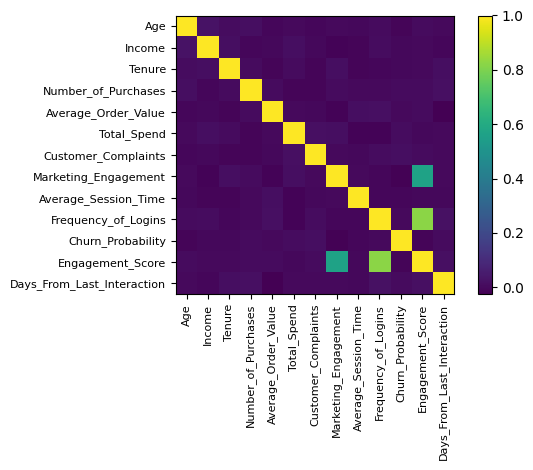

In [ ]:
plt.imshow(df[numeric_features].corr(), cmap='viridis')
plt.xticks(range(len(numeric_features)), numeric_features, rotation=90,fontsize=8)
plt.yticks(range(len(numeric_features)), numeric_features,fontsize=8)
plt.colorbar()
plt.tight_layout()

In [ ]:
#sns.pairplot(df[numeric_features])

Conclusions:

The Good News: High correlation between features can potentially hurt models, specifically logistic regression. For example the model would probably benefit from removal of the Engagment_Score feature which is highly correlated with Frequency_of_Login and moderately correlated with Marketing_Engagement. Removal of this feature will not be done in the baseline model, but will be done in the more advanced logistic regression model, in the hopes that the model predictions improve.

The Bad News: All Other features seem to have zero correlation between them. This potentially means that the feature values are randomly generated and no underlying patterns exist to train an ML model on. Still we can be optimistic, perhaps non-linear interactions exist between the features which are not captured by the correlation matrix.


### Missing Values: Are they randomally missing or is there an underlying pattern?
If missing values are completely at random (MCAR), median imputation can be used as a simple method to replace missing values, minimizing the risk of introducing bias. To answer this question I performed t-tests for Numerical Features, comparing the distribution of the entire feature, with the distribution of the missing values in all other features.

For example, The 1000 missing Age values have their Income values distribution compared to that of all other Income values. If the distributions are different (p-value < 0.05) then perhaps there's a link between missing Age values and the level of Income, i.e. not random, and more complex imputation techniques are in order.

For Categorical Features a Chi-Square test was performed to assess randomness of missing values, or lack thereof.

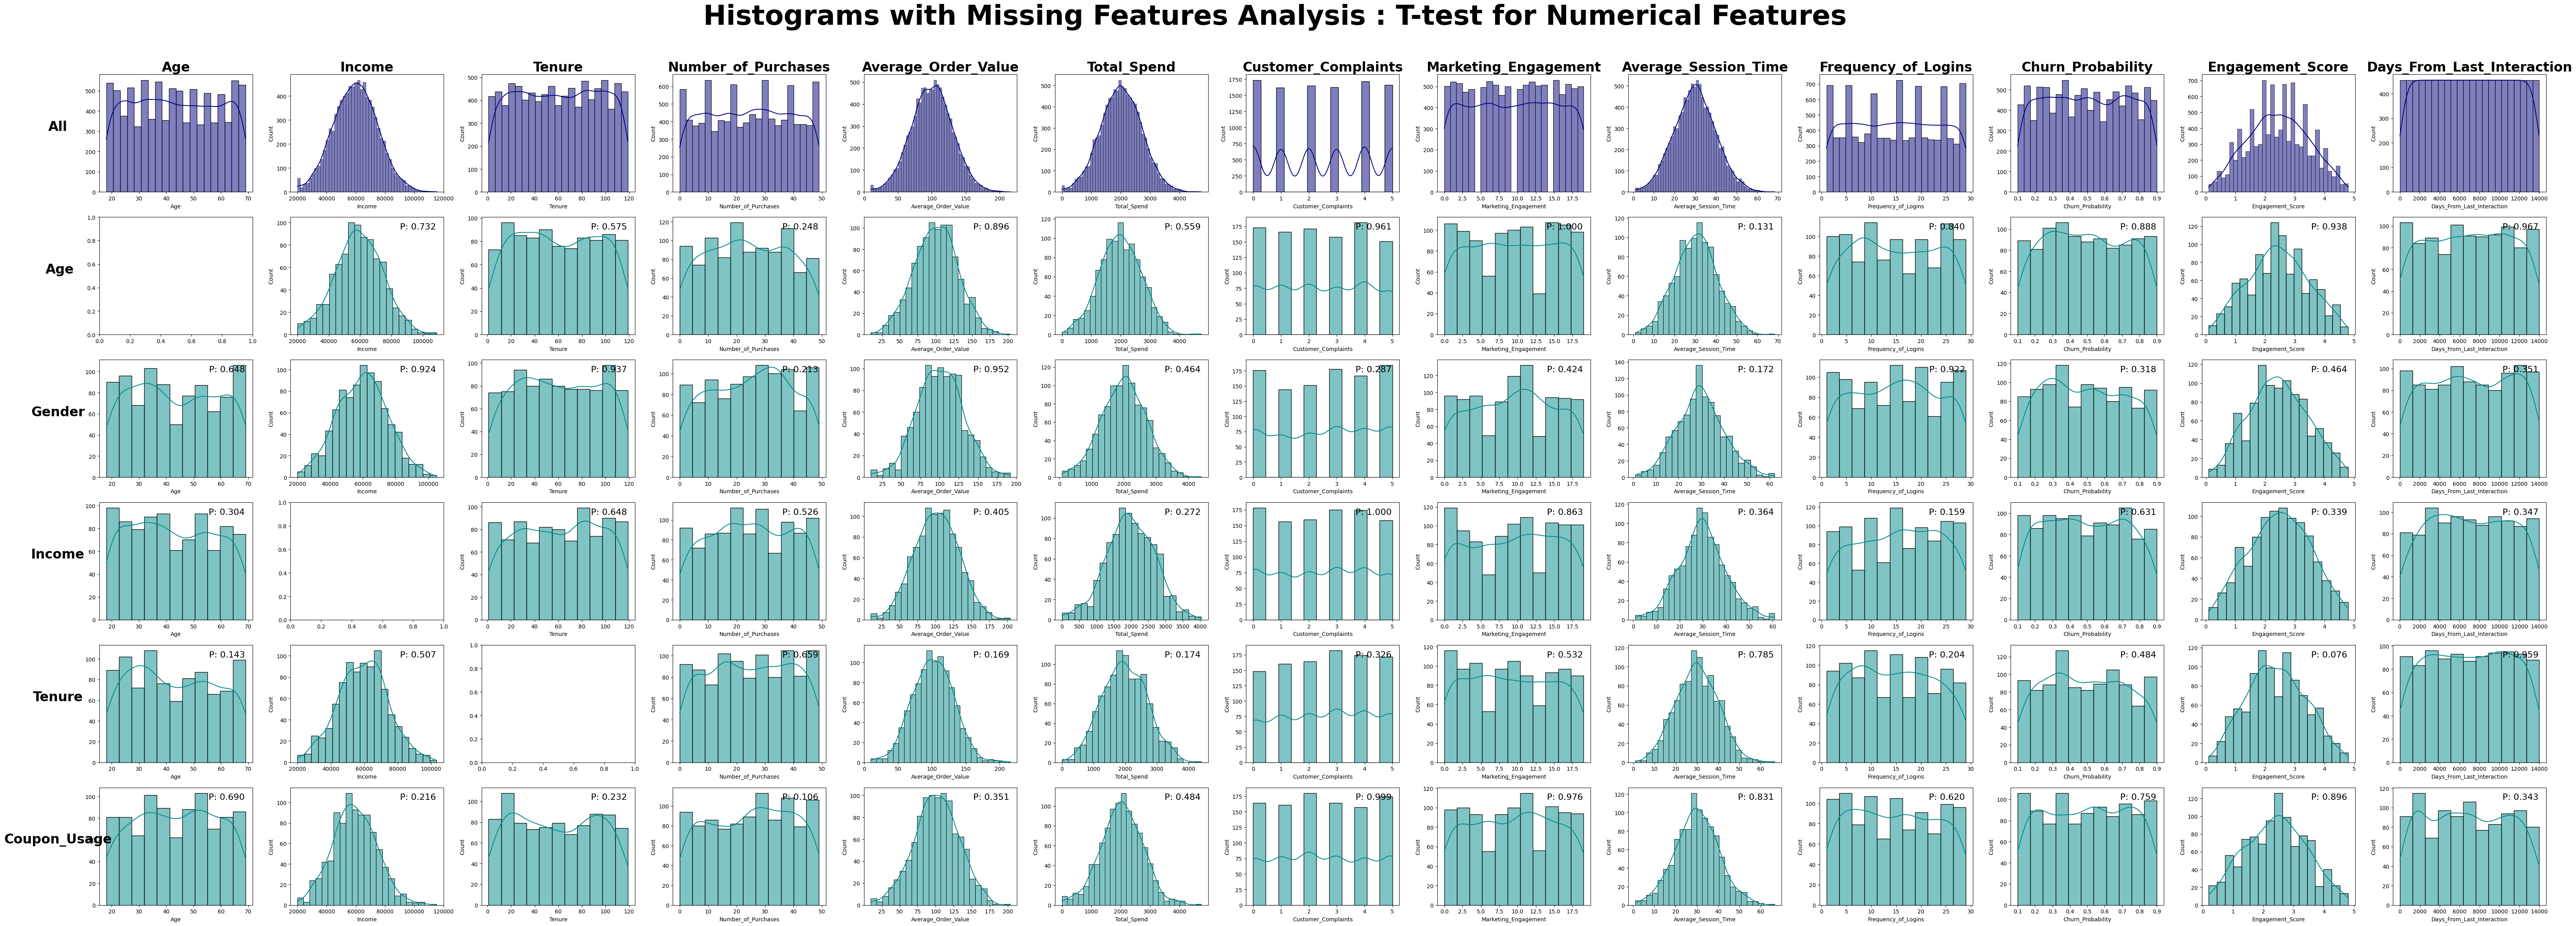

In [ ]:

# Identify features with missing values
missing_features = [col for col in df.columns if df[col].isnull().sum() > 0]

# Create the figure and axes
n_rows = len(missing_features) + 1
n_cols = len(numeric_features)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), sharex=False, sharey=False)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Add titles for rows and columns
for col_idx, feature in enumerate(numeric_features):
    axes[0, col_idx].set_title(feature, fontsize=24, fontweight='bold')
for row_idx, missing_feature in enumerate(["All"] + missing_features):
    axes[row_idx, 0].set_ylabel(missing_feature, fontsize=24, fontweight='bold', rotation=0, labelpad=50)

# Plot the histograms
for col_idx, feature in enumerate(numeric_features):
    # Top row: Histograms for all values (Not missing)
    sns.histplot(df[feature].dropna(), kde=True, ax=axes[0, col_idx], color='navy')

    # Rows for features with missing values
    for row_idx, missing_feature in enumerate(missing_features, start=1):
        with_missing = df.loc[df[missing_feature].isnull(), feature].dropna()
        without_missing = df.loc[df[missing_feature].notnull(), feature].dropna()

        if len(with_missing) > 0 and len(without_missing) > 0:
            # Perform t-test
            stat, p_value = ks_2samp(with_missing, without_missing)#, equal_var=False)

            # Plot histogram
            color = 'red' if p_value < 0.05 else 'darkcyan'
            sns.histplot(with_missing, kde=True, ax=axes[row_idx, col_idx], color=color)

            # Add p-value text
            axes[row_idx, col_idx].text(
                0.95, 0.95, f"P: {p_value:.3f}", ha='right', va='top', transform=axes[row_idx, col_idx].transAxes,
                color='red' if p_value < 0.05 else 'black', fontsize=24 if p_value < 0.05 else 16, fontweight='bold' if p_value < 0.05 else 'normal'
            )

plt.suptitle("Histograms with Missing Features Analysis : T-test for Numerical Features", fontsize=50, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The top row shows the distribution of all values, for each numeric feature.
Each subsequent row represents missing values of a different feature, where each feature's distribution is compared to the distribution in the first row.
All missing values' distributions have a similar sample distribution with their 'parent' (=top row) feature (p-value>0.05 Kolmogorov-Smirnov test).


The same analysis was repeated for the Target Variable and Categorical Features, using chi-square test:







In [ ]:
df.insert(0, 'Retention_Status', y)
categorical_features = ['Retention_Status'] + list(categorical_features)

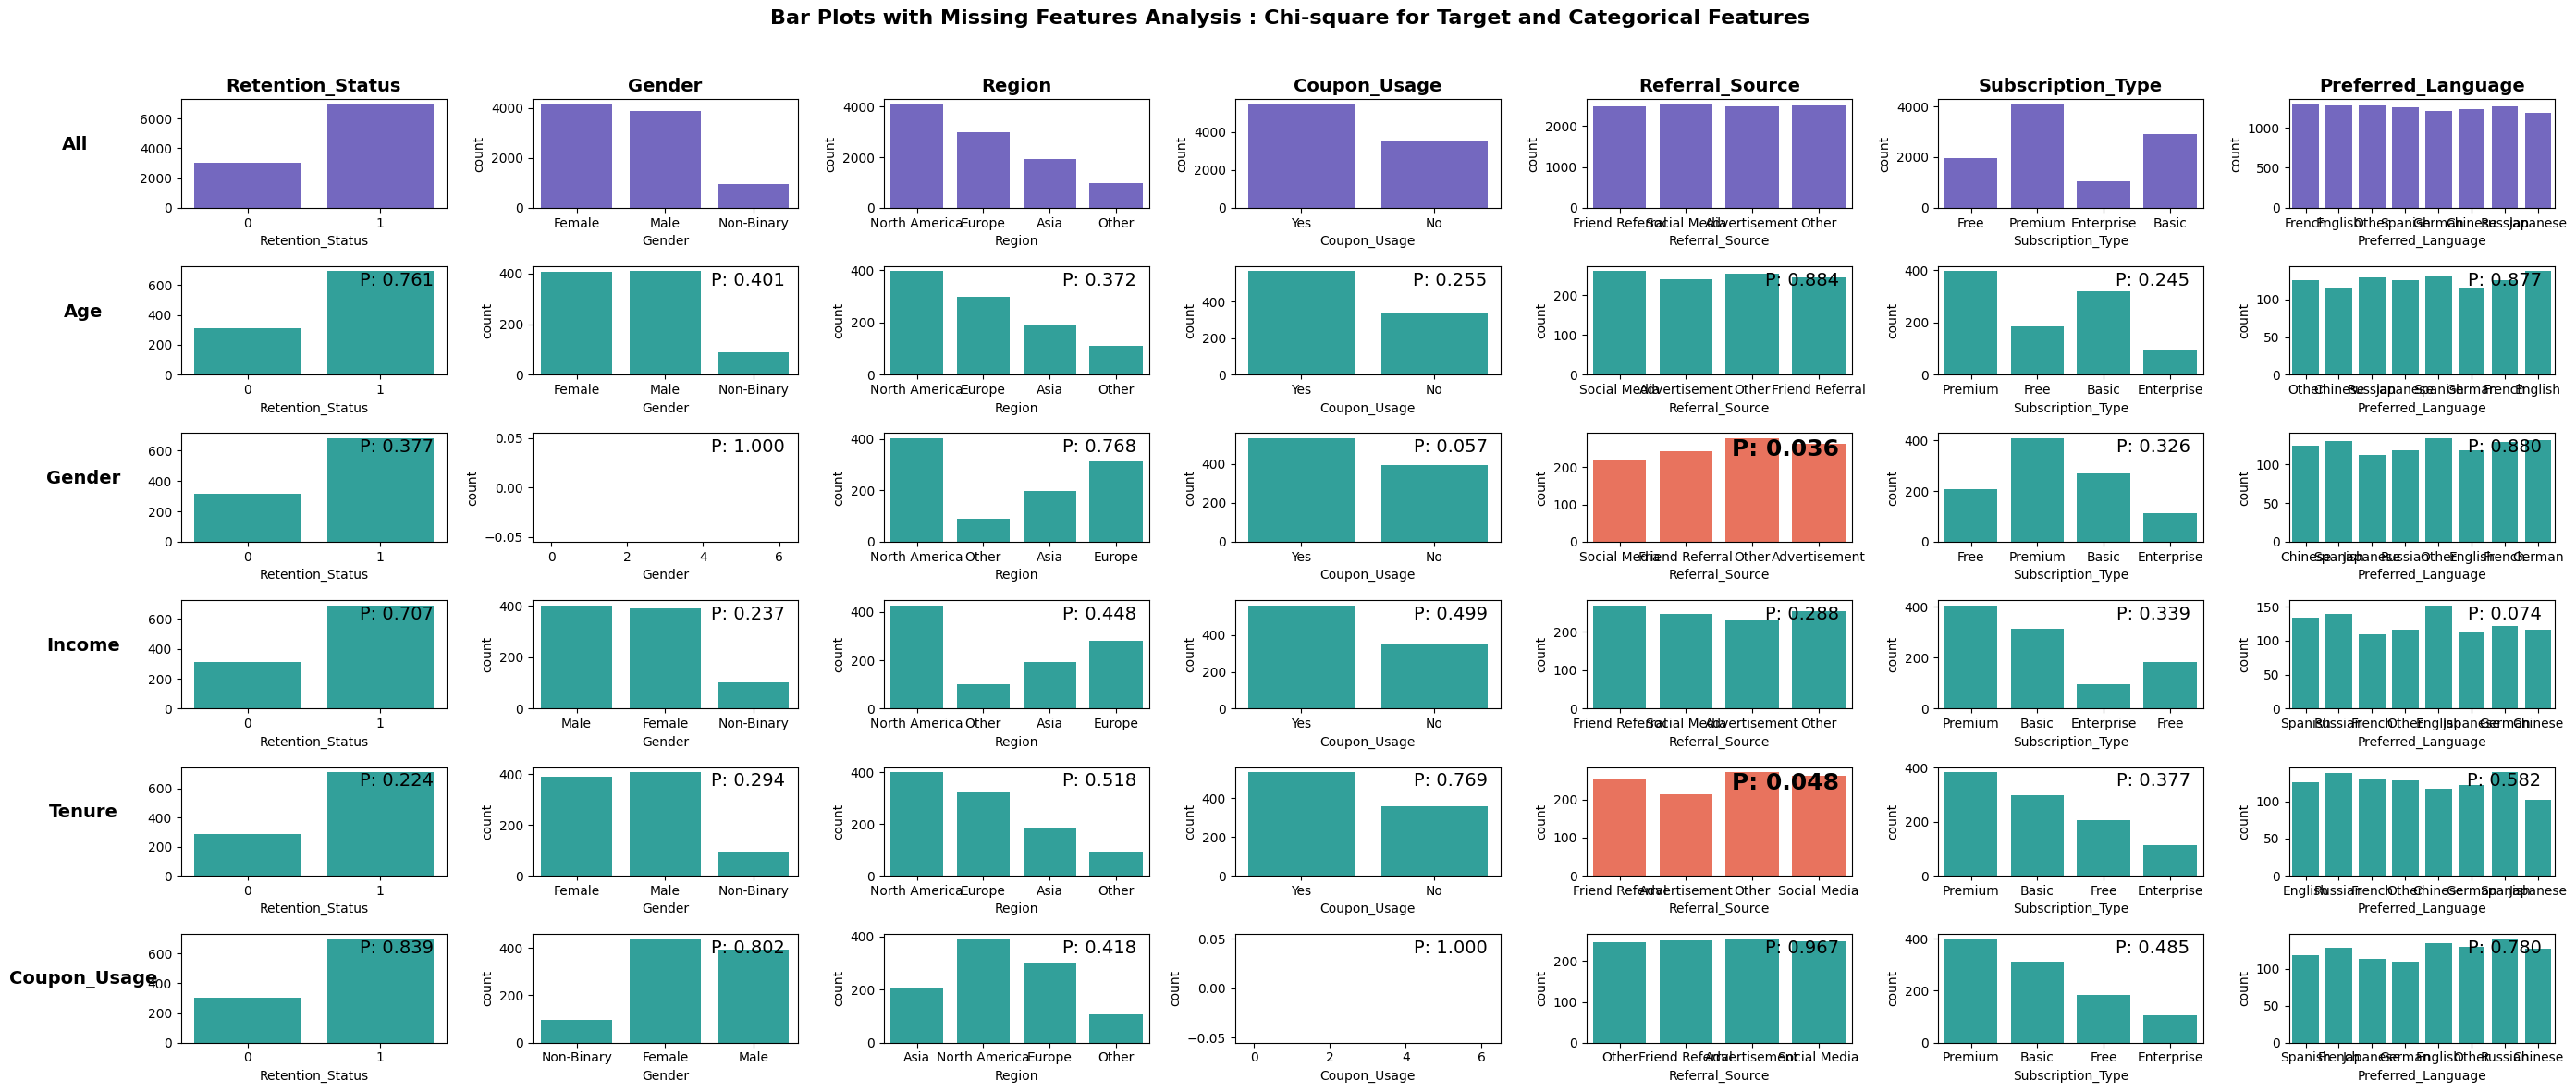

In [ ]:

# Create the figure and axes
n_rows = len(missing_features) + 1
n_cols = len(categorical_features)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Add titles for rows and columns
for col_idx, feature in enumerate(categorical_features):
    axes[0, col_idx].set_title(feature, fontsize=14, fontweight='bold')
for row_idx, missing_feature in enumerate(["All"] + missing_features):
    axes[row_idx, 0].set_ylabel(missing_feature, fontsize=14, fontweight='bold', rotation=0, labelpad=50)

# Plot bar plots
for col_idx, feature in enumerate(categorical_features):
    # Top row: Bar plots for all values (Not missing)
    sns.countplot(x=df[feature], ax=axes[0, col_idx], color='slateblue')

    # Rows for features with missing values
    for row_idx, missing_feature in enumerate(missing_features, start=1):
        contingency_table = pd.crosstab(df[feature], df[missing_feature].isnull())
        chi2, p_value, _, _ = chi2_contingency(contingency_table)

        # Plot bar plot
        color = 'tomato' if p_value < 0.05 else 'lightseagreen'
        sns.countplot(
            x=df.loc[df[missing_feature].isnull(), feature],
            ax=axes[row_idx, col_idx],
            color=color
        )

        # Add p-value text
        axes[row_idx, col_idx].text(
            0.95, 0.95, f"P: {p_value:.3f}", ha='right', va='top', transform=axes[row_idx, col_idx].transAxes,
            color='black', fontsize=18 if p_value < 0.05 else 14, fontweight='bold' if p_value < 0.05 else 'normal'
        )

plt.suptitle("Bar Plots with Missing Features Analysis : Chi-square for Target and Categorical Features", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Conclusions for Randomness of Missing Values:
1. The vast majority of the distributions are similar for both missing and nonmissing values indicating that no underlying reason exists for values being missing other than random omission.
2. Two missing values distributions differ from their 'parent' (top row distribution). However, the p-value, while below 0.05, is very close to the threshold. These results are not surprising, as approximately 33 statistical tests were performed, and a p-value of 0.05 implies a False Discovery Rate (FDR) of 0.05*33 = 1.65 . To control the FDR, the p-value threshold can be reduced, which would render these results non-significant.
3. I will use SimpleImputer in the simple Logistic Regression model, and use the median value. I will use a more advanced imputation approach, IterativeImputer, in advanced preprocessing transformation.


### Dividing Dataset into Training and Test sets
The training set will undergo different preprocessing transformation as per the specific model, and will be further divided into Training and Validation sets The. Test set will be identical across different models so their performance can be compared.

In [ ]:
df = df.iloc[:,1:]
categorical_features.remove('Retention_Status')

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=123, stratify=y
)

## Baseline Logistic Regression Model with Simple Preprocessing Transformations:

In [ ]:
categorical_features = df.select_dtypes(include=['object']).columns
numeric_std_features = ['Income','Average_Order_Value','Total_Spend','Average_Session_Time','Engagement_Score']
numeric_minmax_features = list(set(numeric_features) - set(numeric_std_features))


Simple Preprocessing Transformation:
1. Missing values of categorical features are added in a new 'missing'. an alternative is to use the mode value. Ideally this consideration would have to be discussed with other stakeholders to determine the proper course of action, or both options are to be tested and compared.
2. Categorical features are encoded using OneHotEncoder
3. Missing values of numerical features are replaced with the median value
4. Uniformly distributed numerical features that have hard boundaries are normalized using MinMaxScaler
5. Normally distributed numerical features are standardized using StandardScaler.


In [ ]:
# Define preprocessing steps
preprocessor_simple_logreg = ColumnTransformer(
    transformers=[
        ('categorical', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features),

        ('standard', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_std_features),

        ('minmax', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler())
        ]), numeric_minmax_features)
    ])

In [ ]:
# Perform Transformation
X_train_simple_logreg_transformed = preprocessor_simple_logreg.fit_transform(X_train)
onehot_features = preprocessor_simple_logreg.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = list(onehot_features) + numeric_std_features + numeric_minmax_features
X_train_simple_logreg_transformed = pd.DataFrame(X_train_simple_logreg_transformed, columns=all_features)

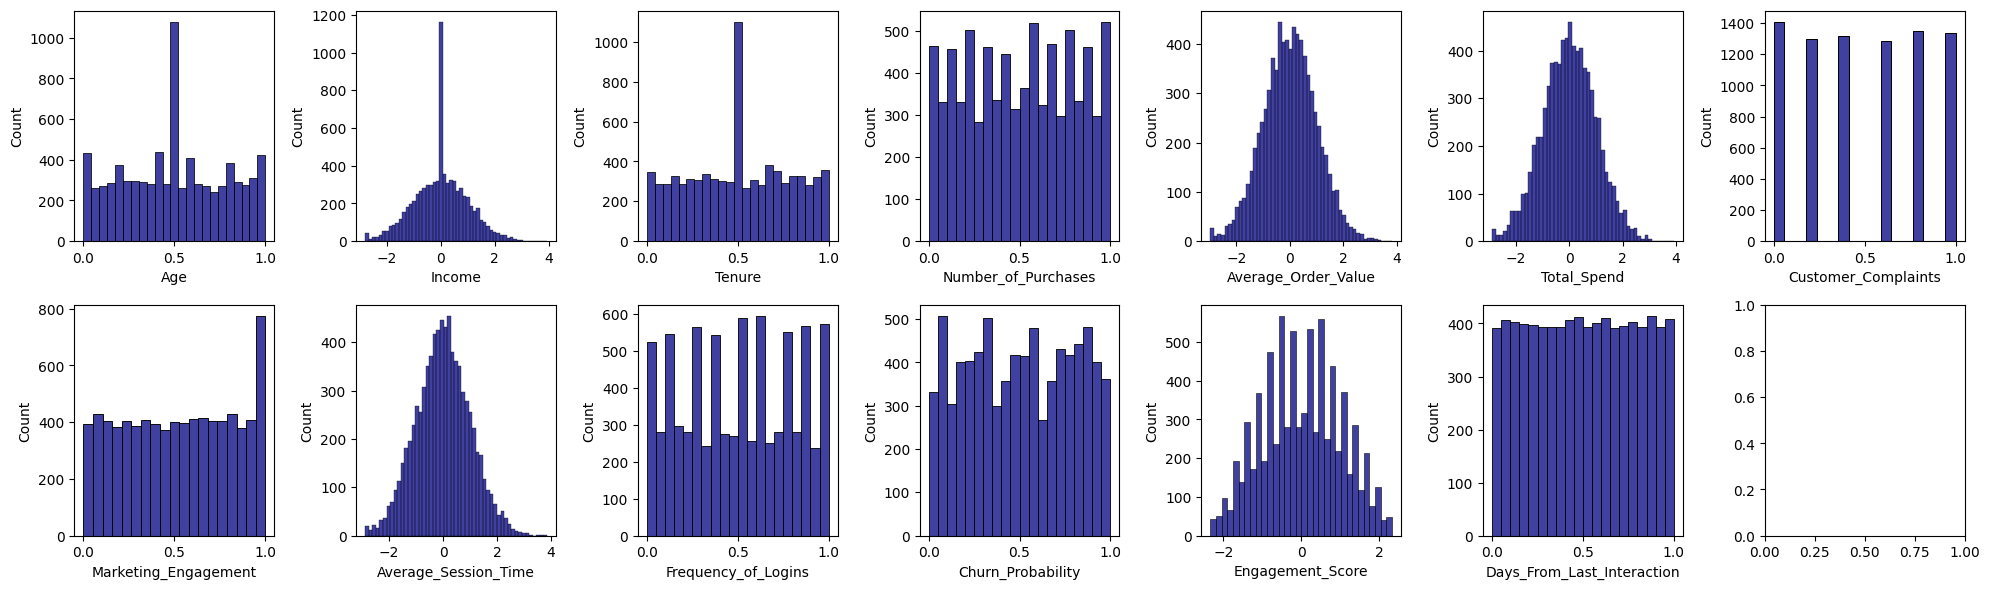

In [ ]:
# Visualize the numerical features after missing values imputation and scaling
fig,axs = plt.subplots(2,int(len(numeric_features)/2)+1,figsize=(20,6))
for i,ax in enumerate(axs.flatten()):
  if i < len(numeric_features):
    sns.histplot(X_train_simple_logreg_transformed[numeric_features],x=numeric_features[i],ax=ax,color = 'navy')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize the categorical features' onehotencoding
X_train_simple_logreg_transformed.head()

,Gender_Female,Gender_Male,Gender_Non-Binary,Gender_missing,Region_Asia,Region_Europe,Region_North America,Region_Other,Coupon_Usage_No,Coupon_Usage_Yes,Coupon_Usage_missing,Referral_Source_Advertisement,Referral_Source_Friend Referral,Referral_Source_Other,Referral_Source_Social Media,Subscription_Type_Basic,Subscription_Type_Enterprise,Subscription_Type_Free,Subscription_Type_Premium,Preferred_Language_Chinese,Preferred_Language_English,Preferred_Language_French,Preferred_Language_German,Preferred_Language_Japanese,Preferred_Language_Other,Preferred_Language_Russian,Preferred_Language_Spanish,Income,Average_Order_Value,Total_Spend,Average_Session_Time,Engagement_Score,Tenure,Customer_Complaints,Churn_Probability,Frequency_of_Logins,Number_of_Purchases,Age,Days_From_Last_Interaction,Marketing_Engagement
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.176046,1.194988,-0.373513,0.461058,0.738944,0.508475,0.0,0.2500,0.428571,0.918367,0.274510,0.895177,1.000000
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.989607,-1.096172,0.717756,0.222335,-1.043881,0.127119,0.0,0.0750,0.142857,0.938776,0.294118,0.097178,0.473684
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.591916,-0.110375,1.265991,0.339199,-0.548652,0.254237,0.6,0.0750,0.607143,0.795918,0.490196,0.888817,0.052632
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.469052,0.839070,-1.591250,0.623870,-0.746744,0.720339,0.8,0.3625,0.000000,0.530612,0.764706,0.808217,0.842105
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.827557,-0.810975,1.500741,-0.672628,1.432265,0.474576,0.4,0.9375,0.821429,0.102041,0.862745,0.914898,0.789474


### Training the model:
Stratified K-fold cross validation to deal with imbalanced target variable.

I used the ROC-AUC metric since this is an imbalanced dataset and I don't have any input as to which errors are more valuable for the marketing team / other stakeholders. ROC-AUC is a comprehensive, comparable metric that is applicable to imbalanced datasets and does not require a specific threshold, but shows results across all thresholds. Otherwise Recall (if False Negatives are costly) , Precision (if False Positives are costly) or F1 (harmonic mean of both) can be used


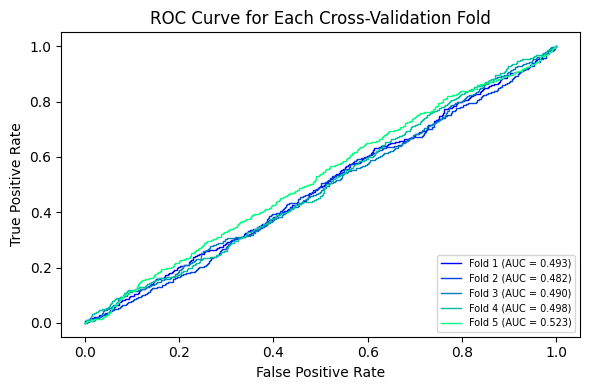

Mean CV ROC AUC: 0.4972
CV ROC AUC Std: 0.0141


In [ ]:
# Define the StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Initialize the model
model = LogisticRegression(class_weight='balanced', random_state=123)
roc_aucs = []

# Create a figure to plot the ROC curve of all cross-validation folds
plt.figure(figsize=(6, 4))
cmap = matplotlib.colormaps['winter']
colors = cmap(np.linspace(0, 1, 5))

# Perform cross-validation
for i, (train_idx, val_idx) in enumerate(cv.split(X_train_simple_logreg_transformed, y_train)):
    X_train_cv, X_val_cv = X_train_simple_logreg_transformed.iloc[train_idx], X_train_simple_logreg_transformed.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

    # Fit the model
    model.fit(X_train_cv, y_train_cv)

    # Predict probabilities for the test set
    y_pred_proba_cv = model.predict_proba(X_val_cv)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_val_cv, y_pred_proba_cv)
    roc_auc = auc(fpr, tpr)

    # Store the ROC AUC
    roc_aucs.append(roc_auc)

    # Plot the ROC curve for this fold
    plt.plot(fpr, tpr, lw=1, color = colors[i],label=f'Fold {i+1} (AUC = {roc_auc:.3f})')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Cross-Validation Fold')
plt.legend(loc="lower right",fontsize=7)
plt.tight_layout()
plt.show()

# Calculate mean and standard deviation of the ROC AUC across all folds
mean_roc_auc = np.mean(roc_aucs)
std_roc_auc = np.std(roc_aucs)
print(f"Mean CV ROC AUC: {mean_roc_auc:.4f}")
print(f"CV ROC AUC Std: {std_roc_auc:.4f}")


see conclusions below

### Model Results
Trainig the model on the entire training dataset, and applying predictions to the testset:

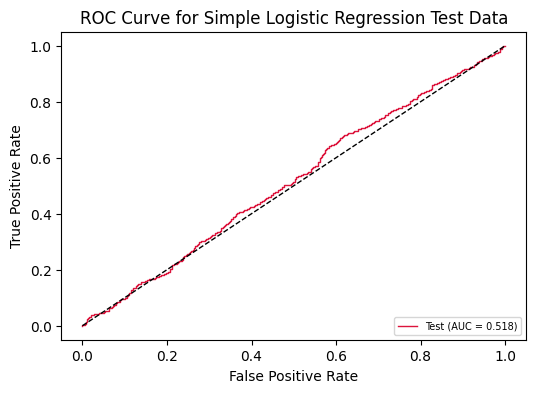

In [ ]:
def testset_evaluation(title, model, X_train, y_train, X_test, y_test, preprocessor):
  model.fit(X_train, y_train)
  X_test = preprocessor.transform(X_test)
  y_hat = model.predict_proba(X_test)
  fpr, tpr, thresholds = roc_curve(y_test, y_hat[:, 1])
  roc_auc = auc(fpr, tpr)
  plt.figure(figsize=(6, 4))
  plt.plot(fpr, tpr, lw=1, color = 'crimson',label=f'Test (AUC = {roc_auc:.3f})')
  plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {title} Test Data')
  plt.legend(loc="lower right",fontsize=7)
  plt.show()
  return

testset_evaluation('Simple Logistic Regression', LogisticRegression(class_weight='balanced',random_state=123),
                   X_train_simple_logreg_transformed,
                   y_train,
                   X_test,
                   y_test,
                   preprocessor_simple_logreg)

Conclusions:
1. The mean ROC-AUC score is ~0.5 which means the model is equivalent to randomly guessing the target labels. These results further strengthen the suspicion from before - Features are randomly generated and there is no underlying pattern that governs them.
2. Still, perhaps a more advanced model, such as Random Forest can potentially capture nonlinear interactions.
3. I will continue with an advanced Logistic Regression model in order to demonstrate how I would approach a similar problem. However in this particular instance it'll probably not improve the model's predictions too much.


## More Advanced Logistic Regression Model

Removing of the Engagement_Score feature, which is highly correlated with two other features, see above correlation matrix.

In [ ]:
# Removing Engagemnt_Score
X_train_advanced_logred = X_train.copy(deep=True).drop('Engagement_Score', axis=1)
categorical_features = df.select_dtypes(include=['object']).columns
numeric_std_features = ['Income','Average_Order_Value','Total_Spend','Average_Session_Time']
numeric_minmax_features = list(set(numeric_features) - set(numeric_std_features))
numeric_minmax_features.remove('Engagement_Score')

More Advanced Preprocessing Transformation:

same as before, the only difference is in imputing miising values for numerical features:
1. Missing values of categorical features are added in a new 'missing' category.
2. Categorical features are encoded using OneHotEncoder
3. Missing values of numerical features are imputed using iterativeImputer, which uses dependencies between other feature's values and the missing values of the specific feature to predict the missing values. K-nearest neighbors may also be used, and is a less computationally complex method. however since this is a small dataset complexity is not an issue.
4. Uniformly distributed numerical features that have hard boundaries are normalized using MinMaxScaler
5. Randomly distributed numerical features are standardized using StandardScaler.


In [ ]:
# Define preprocessing steps
preprocessor_advanced_logreg = ColumnTransformer(
    transformers=[
        ('categorical', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features),

        ('standard', Pipeline([
            ('imputer', IterativeImputer(random_state=123)),
            ('scaler', StandardScaler())
        ]), numeric_std_features),

        ('minmax', Pipeline([
            ('imputer', IterativeImputer(random_state=123)),
            ('scaler', MinMaxScaler())
        ]), numeric_minmax_features)
    ])

In [ ]:
# Perform Transformation
X_train_advanced_logred_transformed = preprocessor_advanced_logreg.fit_transform(X_train_advanced_logred)
indices = X_train.index
onehot_features = preprocessor_advanced_logreg.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_features = list(onehot_features) + numeric_std_features + numeric_minmax_features
X_train_advanced_logred_transformed = pd.DataFrame(X_train_advanced_logred_transformed, columns=all_features, index = indices)


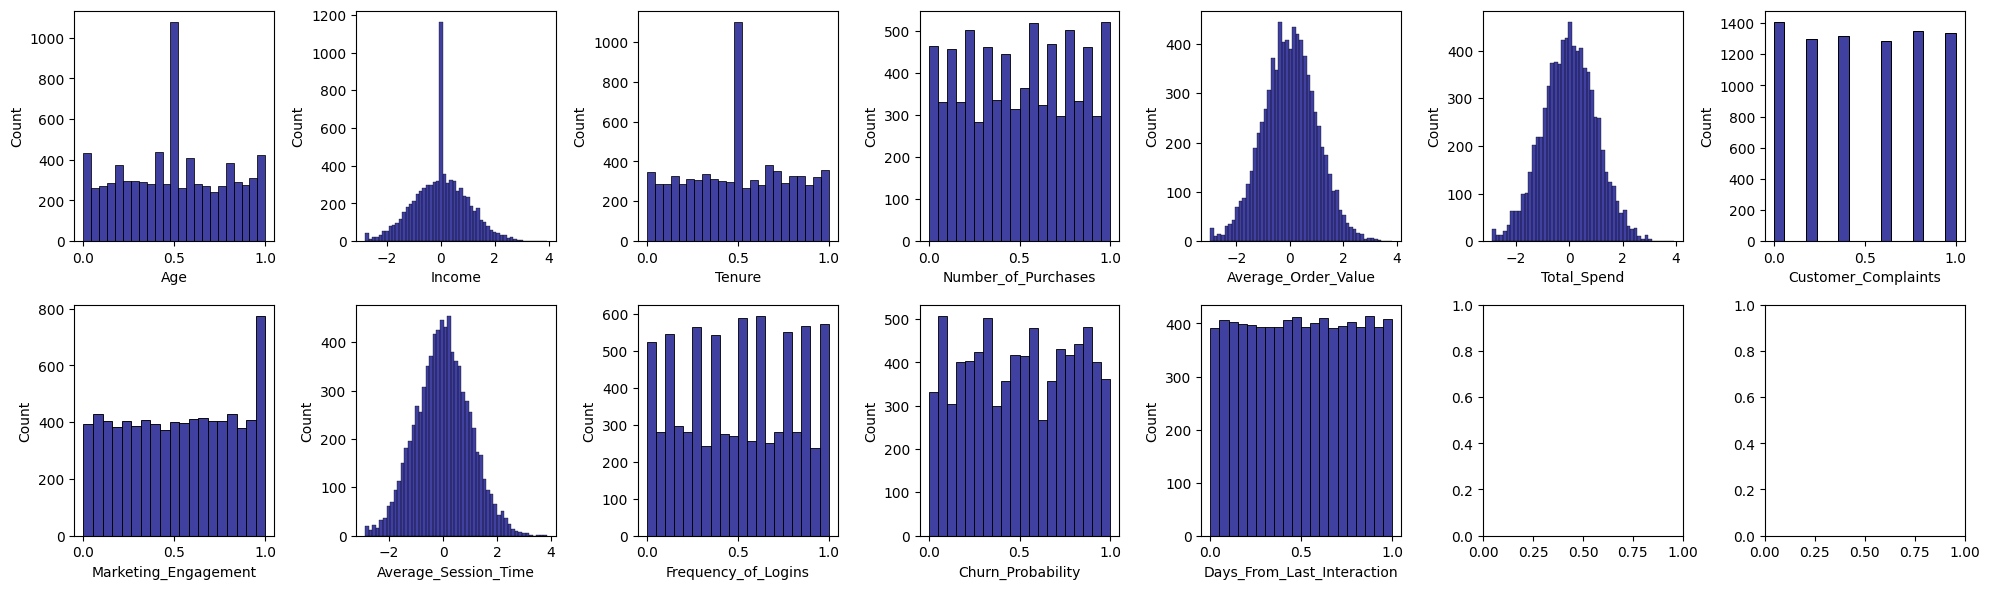

In [ ]:
# Visualize the numerical features after missing values imputation and scaling
fig,axs = plt.subplots(2,int(len(numeric_features)/2)+1,figsize=(20,6))
numeric_features = numeric_features.drop('Engagement_Score')
for i,ax in enumerate(axs.flatten()):
  if i < len(numeric_features):
    sns.histplot(X_train_advanced_logred_transformed[numeric_features],x=numeric_features[i],ax=ax,color = 'navy')
plt.tight_layout()
plt.show()

Conclusion: The resulting distributions are similar to the distributions after SimpleImputer, that's probably due to the lack of correlation between the features. Since the features are randomly generated, IterativeImputer cannot provide significant contributions above its initial imputation, which is the median same as with SimpleImputer.

Removing outliers of normally distributed numerical features to improve model performance. I used a cutoff of z-score above 3 and below -3. Were this a real world example I would discuss with other stakeholders to determine a cutoff that makes actual sense.

In [ ]:
mask = X_train_advanced_logred_transformed.apply(lambda x: (x > 3) | (x < -3)).any(axis=1)
X_train_advanced_logred_transformed = X_train_advanced_logred_transformed[~mask].reset_index(drop=True)
y_train_advanced_logred = y_train[~mask].reset_index(drop=True)

#### Regularization: Using GridSearchCV to screen several regularization parameters:
L1 vs L2 regularization.
Ranging strength of regularization: 0.01-1.

More advanced analysis can include Elasticnet which is a combination of both L1 and L2 regularizations.

In [ ]:
# Define StratifiedKFold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# Parameter Grid search for logistic regression
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.03, 0.1, 0.3, 1],
    'solver': ['liblinear']
}
log_reg = LogisticRegression(class_weight='balanced',random_state=123)
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_advanced_logred_transformed, y_train_advanced_logred)

best_params = grid_search.best_params_


In [ ]:
# Results summary
sorted_idx = np.argsort(grid_search.cv_results_["mean_test_score"])[::-1]
results_df = pd.DataFrame(grid_search.cv_results_["params"]).iloc[sorted_idx].reset_index(drop=True)
results_df.insert(0, 'std_test_score', [round(grid_search.cv_results_["std_test_score"][i],4) for i in sorted_idx])
results_df.insert(0, 'mean_test_score', [round(grid_search.cv_results_["mean_test_score"][i],4) for i in sorted_idx])

print(results_df.iloc[:,:-1])

   mean_test_score  std_test_score     C penalty
0           0.5081          0.0095  0.03      l1
1           0.5026          0.0110  1.00      l1
2           0.5024          0.0108  1.00      l2
3           0.5024          0.0107  0.30      l2
4           0.5023          0.0105  0.10      l2
5           0.5019          0.0098  0.03      l2
6           0.5019          0.0097  0.30      l1
7           0.5015          0.0025  0.01      l1
8           0.5012          0.0082  0.01      l2
9           0.4992          0.0057  0.10      l1


Conclusions:
1. As expected the Linear Regression model results in an ROC-AUC of ~0.5 which is similar to a random guess
2. the different regularization parameters do not change the results, all mean scores fall within the standard deviations.


#### Feature Importance
The importance of a feature in the logistic regression model is reflected by the absolute value of its respective weight.
Here I measure the effect of the different regularization parameters on the weight distributions.
Specifically, L1 regularization removes features with marginal contribution to the model prediction metric. Features that are removed in this fashion can be used to improve more advanced models, i.e train the model without including these features in the hope the prediction metric will improve.


In [ ]:
# Function to extract and calculate mean absolute feature weights
def extract_feature_weights(grid_search, X, y, features, penalty_type, cv):
    weights_df = pd.DataFrame(index=features)

    for params in grid_search.cv_results_['params']:
        if params['penalty'] == penalty_type:
            # Collect weights from each fold
            fold_weights = []
            for train_idx, val_idx in cv.split(X, y):
                X_train_fold, X_val_fold = X[train_idx], X[val_idx]
                y_train_fold = y[train_idx]
                model = LogisticRegression(**params, random_state=123).fit(X_train_fold, y_train_fold)
                fold_weights.append(np.abs(model.coef_[0]))

            # Calculate mean across folds
            mean_weights = np.mean(fold_weights, axis=0)
            col_name = f"C={params['C']}"
            weights_df[col_name] = mean_weights

    return weights_df

# Extract L1 and L2 weights
feature_weights_l1 = extract_feature_weights(grid_search, X_train_advanced_logred_transformed.to_numpy(),
                                             y_train_advanced_logred.to_numpy(), all_features, penalty_type='l1', cv=cv)
feature_weights_l2 = extract_feature_weights(grid_search, X_train_advanced_logred_transformed.to_numpy(),
                                             y_train_advanced_logred.to_numpy(), all_features, penalty_type='l2', cv=cv)

# Sort features by their maximum weight
def sort_features_by_max_weight(weights_df):
    return weights_df.max(axis=1).sort_values(ascending=False).index

# Plot L1 and L2 feature weights in subplots
def plot_feature_weights_subplots(weights_l1, weights_l2, sorted_features_l1, sorted_features_l2):
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))

    # Plot L1 weights
    weights_l1.loc[sorted_features_l1].plot(kind='bar', ax=axes[0], rot=270, fontsize=7)
    axes[0].set_title('Feature Weights for L1 Regularization')
    axes[0].set_ylabel('Weight')

    # Plot L2 weights
    weights_l2.loc[sorted_features_l2].plot(kind='bar', ax=axes[1], rot=270, fontsize=7)
    axes[1].set_title('Feature Weights for L2 Regularization')
    axes[1].set_xlabel('Features')
    axes[1].set_ylabel('Weight')

    plt.tight_layout()
    plt.show()


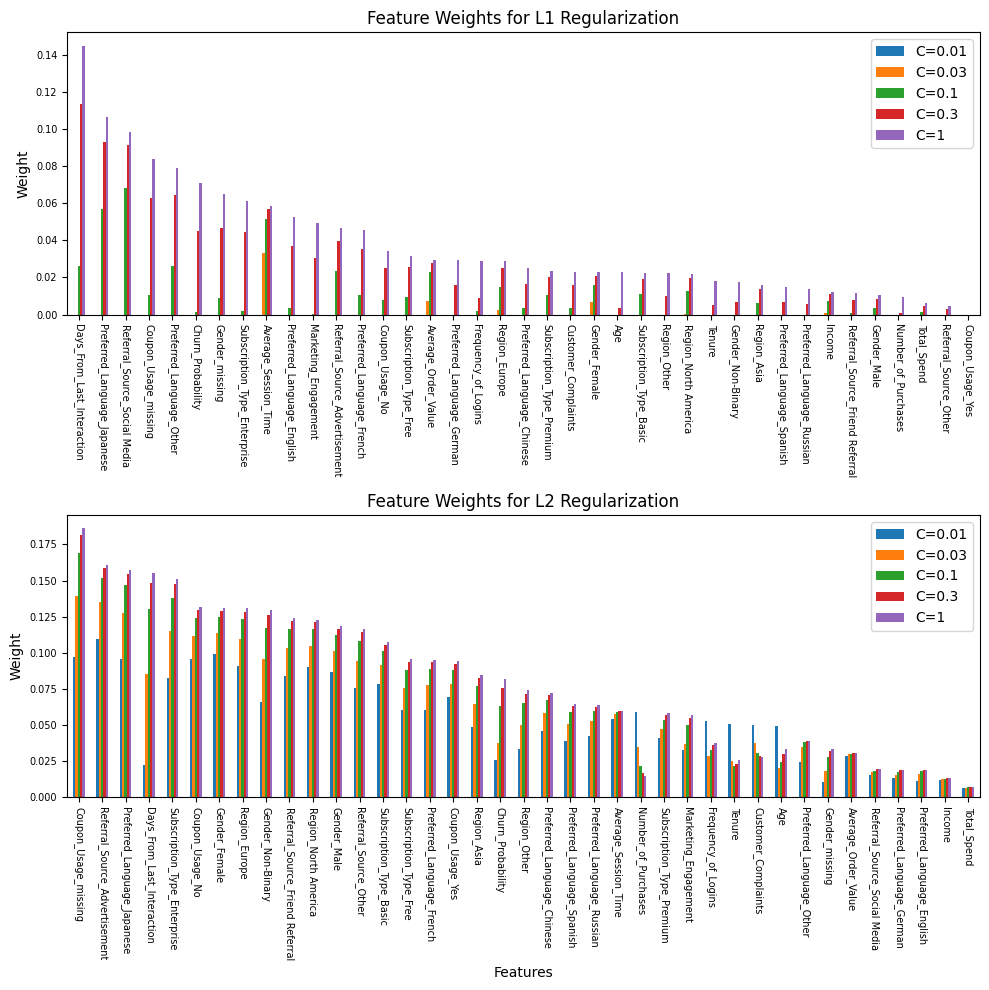

In [ ]:
# Sort features
l1_sorted_features = sort_features_by_max_weight(feature_weights_l1)
l2_sorted_features = sort_features_by_max_weight(feature_weights_l2)

# Plot L1 and L2 feature weights in subplots
plot_feature_weights_subplots(feature_weights_l1, feature_weights_l2, l1_sorted_features, l2_sorted_features)

The analysis above can be used in addition to the model prediction metric to help determine which regularization parameter to choose:
For example, when comparing different L1 models, if two models have a similar prediction metric score, but one uses less features to compute, it could be less prone to overfitting. Examples of how to use feature importance will be further elaborated in the Random Forest model results.


### Model Results
Trainig the model on the entire training dataset, and applying predictions to the testset:

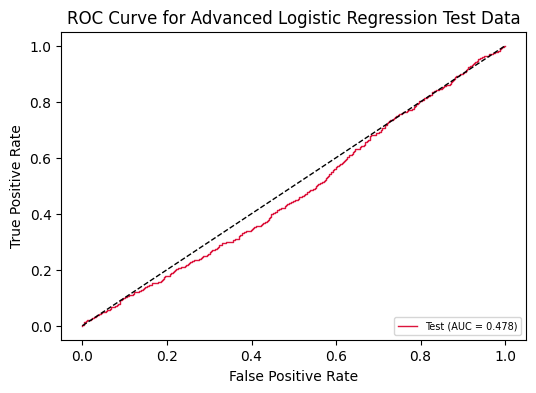

In [ ]:
testset_evaluation('Advanced Logistic Regression',
                   LogisticRegression(**best_params,class_weight='balanced',random_state=123),
                   X_train_advanced_logred_transformed,
                   y_train_advanced_logred,
                   X_test,
                   y_test,
                   preprocessor_advanced_logreg)

### Random Forest Classifier Model

####Reasons for Choosing Random Forest with this Dataset:
Can find nonlinear interactions between features.

Can handle missing values without need for imputing.

Built in feature importance measurements.

Handles outliers well. No need to normalize/standardize numerical feature values.

Robust to collinearity between features.


In [ ]:
X_train_forest = X_train.copy(deep=True).drop('Engagement_Score', axis=1)

In [ ]:
categorical_features

Index(['Gender', 'Region', 'Coupon_Usage', 'Referral_Source', 'Subscription_Type', 'Preferred_Language'], dtype='object')

In [ ]:
numeric_features

Index(['Age', 'Income', 'Tenure', 'Number_of_Purchases', 'Average_Order_Value', 'Total_Spend', 'Customer_Complaints', 'Marketing_Engagement', 'Average_Session_Time', 'Frequency_of_Logins', 'Churn_Probability', 'Days_From_Last_Interaction'], dtype='object')



Simple Preprocessing Transformation for Random Forest:
1. Categorical features are encoded using OneHotEncoder


In [ ]:
# Define preprocessing steps
preprocessor_forest = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('numeric', 'passthrough', numeric_features)
    ]
)

In [ ]:
# Transform the data
X_train_forest_transformed = preprocessor_forest.fit_transform(X_train_forest)
X_train_forest_transformed = pd.DataFrame(X_train_forest_transformed, columns=all_features)

In [ ]:
# Parameter Grid search for Random Forest
param_grid = {
            'criterion': ['gini','entropy'],      # Function to measure the quality of a split
            'n_estimators': [50,100, 200],       # Number of trees in the forest
            'max_depth': [3,5],                 # Maximum depth of the tree
            'min_samples_split': [2,8],          # Minimum samples required to split
            'min_samples_leaf': [ 2, 4],        # Minimum samples at a leaf node
            'max_features': ['sqrt','log2'],     # Number of features for the best split
            'class_weight': ['balanced_subsample']   # Handling class imbalance
      }

rand_forest = RandomForestClassifier(random_state=123)

# GridSearchCV
grid_search = GridSearchCV(estimator=rand_forest, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_forest_transformed, y_train)



GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
             estimator=RandomForestClassifier(random_state=123), n_jobs=-1,
             param_grid={'class_weight': ['balanced_subsample'],
                         'criterion': ['gini', 'entropy'], 'max_depth': [3, 5],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 8],
                         'n_estimators': [50, 100, 200]},
             scoring='roc_auc')

In [ ]:
# Sort the model to show the top 10 best model parameters
sorted_idx = grid_search.cv_results_["mean_test_score"].argsort()[::-1][:10]
mean_test_scores = grid_search.cv_results_["mean_test_score"][sorted_idx]
std_test_scores = grid_search.cv_results_["std_test_score"][sorted_idx]
param_combinations = [grid_search.cv_results_["params"][i] for i in sorted_idx]

# Create a DataFrame with mean test scores and parameters
results_df = pd.DataFrame(param_combinations)
results_df.insert(0, 'std_test_score', [round(score,4) for score in std_test_scores])
results_df.insert(0, 'mean_test_score', [round(score,4) for score in mean_test_scores])

print(results_df)

   mean_test_score  std_test_score        class_weight criterion  max_depth max_features  min_samples_leaf  min_samples_split  n_estimators
0           0.4971          0.0131  balanced_subsample   entropy          5         sqrt                 4                  8            50
1           0.4971          0.0131  balanced_subsample   entropy          5         sqrt                 4                  2            50
2           0.4960          0.0085  balanced_subsample   entropy          5         sqrt                 4                  2           100
3           0.4960          0.0085  balanced_subsample   entropy          5         sqrt                 4                  8           100
4           0.4948          0.0110  balanced_subsample   entropy          5         sqrt                 2                  2            50
5           0.4943          0.0088  balanced_subsample   entropy          5         sqrt                 2                  8           100
6           0.4938  

Conclusions: Random Forest did not find nonlinear interactions between the features to help improve the model's prediction above random guessing. This results strengthen the suspicion that the feature were randomally generated for this dataset.




####Borderline predictions of the model
Taking the best model parameters and applying them to the test set, I want to get a sense of how sure the model is about its predictions. I'm using the margin of confidence as a metric, that is the probability difference between the most likely class and the other class' probability for each instance. Low margin denotes high uncertainty regarding a particular instance. I'm counting the number of instances for each margin threshold.

Ideally, few instances have low margins, while most have high confidence margins.


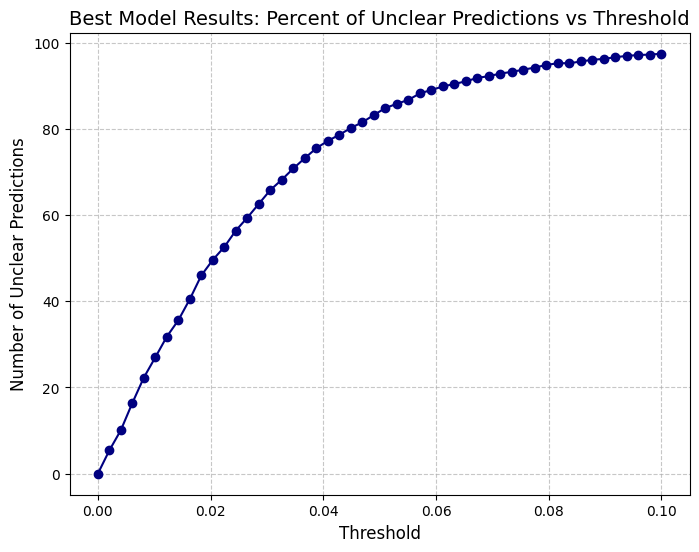

In [ ]:
model = grid_search.best_estimator_
X_test_transformed = preprocessor_forest.transform(X_test)
y_hat = model.predict_proba(X_test_transformed)

# Calculate margins of confidence
margins = np.max(y_hat, axis=1) - np.sort(y_hat, axis=1)[:, -2]

# Analyze unclear predictions for varying thresholds
thresholds = np.linspace(0.0, 0.1, 50)
num_unclear = [round(100*np.sum(margins < t)/len(X_test),1) for t in thresholds]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds, num_unclear, marker='o', color = 'navy')
plt.title("Best Model Results: Percent of Unclear Predictions vs Threshold", fontsize=14)
plt.xlabel("Threshold", fontsize=12)
plt.ylabel("Number of Unclear Predictions", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Not surprisingly, all instances have very low confidence margins, since the values are randomally generated

### Feature Improtance:
In the context of customer retention, understanding feature importance enables identifying the key factors that influence customer retention and enable more targeted and effective marketing campaigns. Customer retention can be improved through the understanding of customer behavior, generating of personalized marketing campaigns and improving resource allocation. Feature importance can also help improve user experience and align product development with user needs.

Below are three examples for feature importance metrics calculations:

1. Using RandomForest built in feature importance analysis: Measures the average reduction in impurity (gini or entropy) across all trees for splits involving the feature. It is fast but can potentially be biased towards numerical features. I averaged the results of the features from the top five best models
2. Using Permutation Importance: Shuffles the values of each feature after training, and measures the influence on model performance. It is less biased but more computationally expensive. Here I also averaged metrics across the top five best models.
3. Feature Dropout: Iteratively trains the model, each time removing a different feature and measuring the change in model performance. It has a very high interpretability - the direct effect of the feature on the model, but very computationally expensive. That is why I only used it on a single sample model - the model with the best ROC_AUC score.




In [ ]:
# Create a DataFrame to store feature importances and permutations for top models
feature_importances_df = pd.DataFrame(columns=X_train_forest_transformed.columns)
permutation_importances_df = pd.DataFrame(columns=X_train_forest_transformed.columns)

for idx in sorted_idx:
    # Recreate the specific model configuration
    params = grid_search.cv_results_['params'][idx]
    model = RandomForestClassifier(
        random_state=123,
        criterion=params['criterion'],
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features'],
        class_weight=params['class_weight']
    )

    # Fit the model
    model.fit(X_train_forest_transformed, y_train)

    # Store feature importances
    feature_importances_df.loc[idx] = model.feature_importances_

    # Compute permutation importance
    perm_importance = permutation_importance(
        model,
        X_train_forest_transformed,
        y_train,
        n_repeats=10,
        random_state=123
    )

    # Store permutation importances
    permutation_importances_df.loc[idx] = perm_importance.importances_mean

# Mean feature importances across top models
mean_feature_importances = feature_importances_df.mean()
std_feature_importances = feature_importances_df.std()

# Mean feature  permutation importances across top models
mean_permutation_importances = permutation_importances_df.mean()
std_permutation_importances = permutation_importances_df.std()


In [ ]:
def plot_feature_importances(importance_data, non_onehotencoded_features,title_suffix=''):
    """
    Create a subplot comparing feature importances

    Parameters:
    - importance_data: List of dictionaries with keys:
      * 'method_name': Name of importance method
      * 'mean_importances': Mean feature importances
      * 'std_importances': Standard deviation of importances
      * 'color': Plot color
    - title_prefix: Optional prefix for subplot titles
    """
    # Determine number of subplots based on input data
    num_subplots = len(importance_data)

    # Create figure with dynamic subplot configuration
    fig, axes = plt.subplots(num_subplots, 1, figsize=(10, 5 * num_subplots))

    # Ensure axes is always a list, even for single subplot
    if num_subplots == 1:
        axes = [axes]

    # Loop through importance methods
    for i, data in enumerate(importance_data):

        # Aggregate individual onehotencoded features: Each into a respective single feature importance value
        non_onehot_data = pd.DataFrame(data = 0, columns = ['mean','std'], index = non_onehotencoded_features)
        for idx_i in non_onehot_data.index:
            for indx_j in data['mean_importances'].index:
                if indx_j.startswith(idx_i):
                    non_onehot_data.loc[idx_i,'mean'] += data['mean_importances'][indx_j]
                    non_onehot_data.loc[idx_i,'std'] += data['std_importances'][indx_j]**2

        data['mean_importances'] = non_onehot_data['mean']
        data['std_importances'] = np.sqrt(non_onehot_data['std'])

        # Sort features by importance
        sorted_idx = data['mean_importances'].argsort()[::-1]

        # Create vertical bar plot
        axes[i].bar(
            x=data['mean_importances'].index[sorted_idx],
            height=data['mean_importances'][sorted_idx],
            yerr=data['std_importances'][sorted_idx],
            capsize=2,
            color=data.get('color', 'royalblue'),
            alpha=0.7
        )

        # Formatting
        axes[i].set_title(f'{str(i+1)}. {data["method_name"]}{title_suffix}')
        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Mean Importance')
        axes[i].set_ylim(0)
        axes[i].set_xticklabels(data['mean_importances'].index[sorted_idx], rotation=90, ha='right')

    plt.tight_layout()
    plt.show()

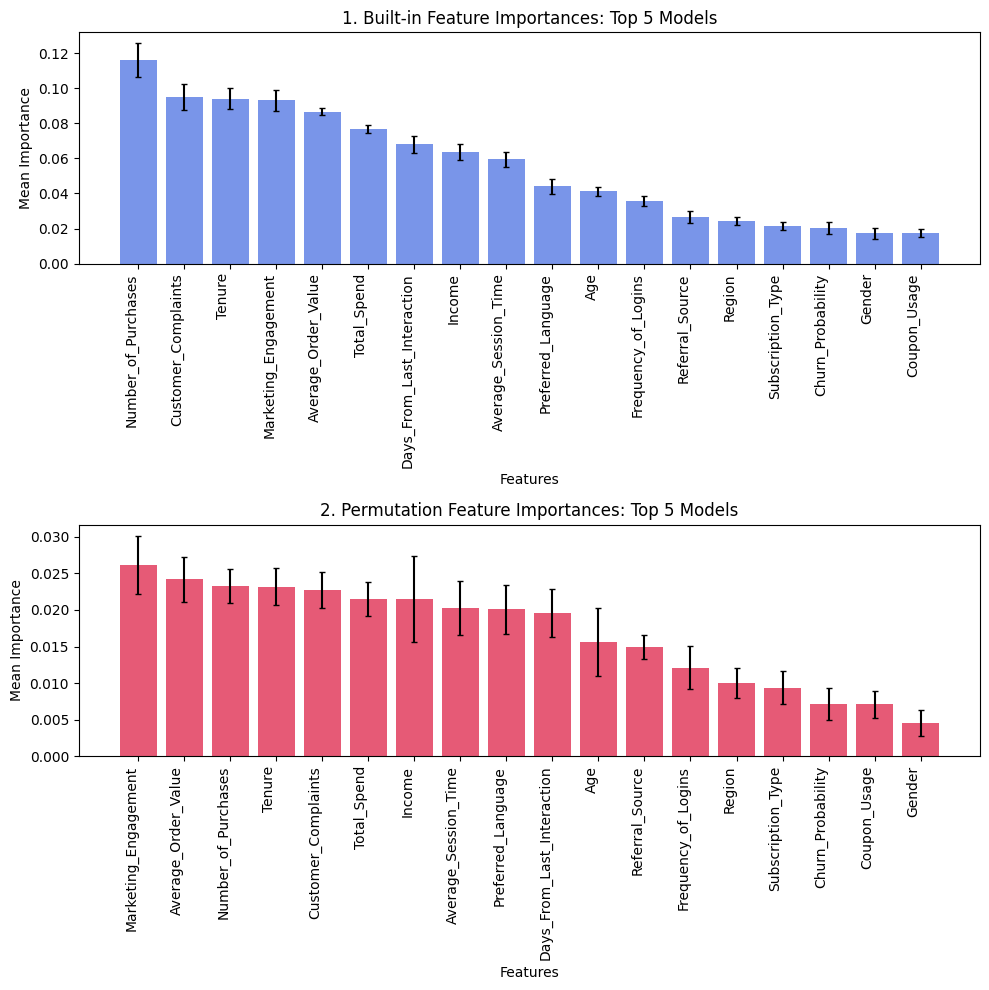

In [ ]:
# Prepare data for plotting
importance_data = [
    {
        'method_name': 'Built-in Feature Importances',
        'mean_importances': mean_feature_importances,
        'std_importances': std_feature_importances,
        'color': 'royalblue'
    },
    {
        'method_name': 'Permutation Feature Importances',
        'mean_importances': mean_permutation_importances,
        'std_importances': std_permutation_importances,
        'color': 'crimson'
    }
]

# Plot both importance methods
plot_feature_importances(
    importance_data,
    list(numeric_features)+list(categorical_features),
    title_suffix=': Top 5 Models'
)

If this were a dataset with real-world values, I would analyze the overlap between the different Feature Importance methods and provide my own insights into why such overlaps exist or are missing. Additionally, I would discuss the possible reasons with relevant stakeholders and include the L1-regularized Logistic Regression Feature Importance analysis in my comparisons.

For example, since Tenure is an important feature in both analyses, I would recommend developing targeted campaigns for new customers (low tenure) to encourage engagement, such as onboarding emails, welcome discounts, or exclusive perks. In addition, I would recommend Rewarding long-tenured customers with tiered loyalty programs, special discounts, or anniversary offers to reinforce their loyalty.

Additional example, Since Gender is not an important feature in both analyses, I would recommend divesting gender-based advertisements and products into more potentially rewarding marketing targeting campaigns.


In [ ]:
def drop_feature_group(X, feature_names, group):
    group_features = [col for col in feature_names if col.startswith(group)]
    X_dropped = X.drop(columns=group_features)
    return X_dropped

In [ ]:
best_model = grid_search.best_estimator_

features_to_test = list(numeric_features)+ list(categorical_features)
results = []

# Iterate through each feature
for feature in features_to_test:
    # Drop the feature group
    X_dropped = drop_feature_group(X_train_forest_transformed, all_features, feature)

    # Retrain model without the feature group and calculate scores
    dropped_scores = cross_val_score(best_model, X_dropped, y_train, cv=5, scoring='roc_auc')
    original_scores = cross_val_score(best_model, X_train_forest_transformed, y_train, cv=5, scoring='roc_auc')

    # Calculate performance drop
    performance_drop = original_scores.mean() - dropped_scores.mean()

    results.append({
        'Feature': feature,
        'Mean_Score_Without_Feature': dropped_scores.mean(),
        'Std_Dev_Without_Feature': dropped_scores.std(),
        'Performance_Drop': performance_drop
    })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Performance_Drop', ascending=False)

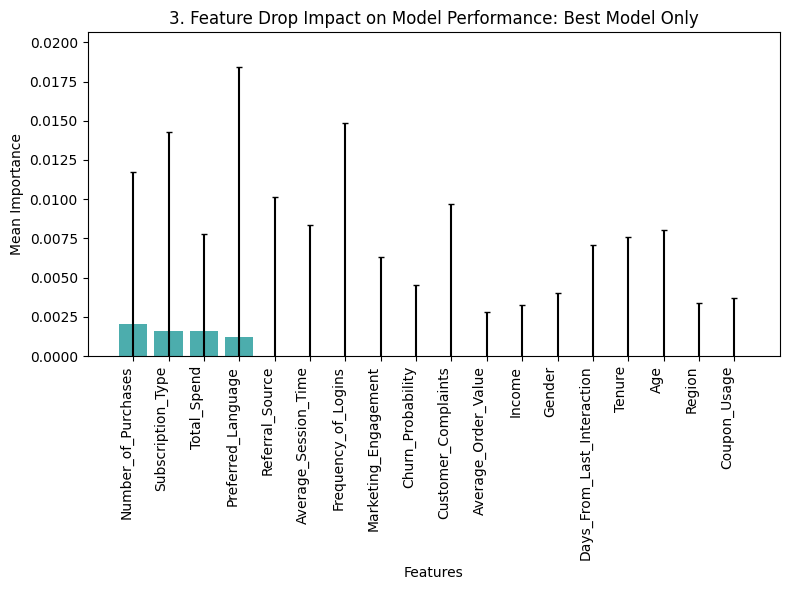

In [ ]:
def plot_feature_drop_impact(feature_drop_data, title_prefix=''):
    """
    Create a vertical bar plot showing feature drop impact on model performance

    Parameters:
    - feature_drop_data: DataFrame with feature drop analysis results
    - title_prefix: Optional prefix for plot title
    """
    plt.figure(figsize=(8, 6))

    # Sort features by performance drop in descending order
    sorted_df = feature_drop_data.sort_values('Performance_Drop', ascending=False)

    # Create vertical bar plot
    plt.bar(
        x=sorted_df['Feature'],
        height=sorted_df['Performance_Drop'],
        yerr=sorted_df['Std_Dev_Without_Feature'],
        capsize=2,
        color='darkcyan',
        alpha=0.7
    )

    # Formatting
    plt.title(f'{title_prefix}Feature Drop Impact on Model Performance: Best Model Only')
    plt.xlabel('Features')
    plt.ylabel('Mean Importance')
    plt.xticks(rotation=90, ha='right')
    plt.ylim(0)
    plt.tight_layout()
    plt.show()

# Plot the feature drop impact
plot_feature_drop_impact(results_df, title_prefix='3. ')

### Other models to consider with this dataset:
Ideally several models are tested and their prediction metrics compared

####SVM
The simple SVM does not handle nonlinear interactions well, but using kernel tricks non-linearity relationships can be extracted. The model can handle imbalances in the dataset using weights. However it has poor scalability with large datasets since it is computationally expensive.

#### XGboost
Handles non-linear relationships, robust to imbalanced data and missing data. Has a built in feature importance ranking. However, it has complex hyperparameter tuning , it is sensitive to outliers and is prone to overfitting. In addition it is computational complex.


